<h2>Predicting Heart Attack Risk</h2>
<h3>Notebook 4: Baseline Model Training and Evaluation</h3>
<p><b>Author: Nikhar Bhavsar</b></p>

<hr>
<p>In this notebook, we establish and evaluate a baseline machine learning model as the first step in our modeling pipeline. This serves as a reference point to compare the performance of more advanced models later. Specifically, we will:</p> 

1. **Train a baseline** **Logistic Regression** model using a pipeline.
2. **Evaluate the model** using key performance metrics:
    - Accuracy
    - Precision
    - Recall
    - F1 Score
    - ROC AUC
3. **Plot the ROC Curve** for visual understanding.

### Table of Contents
1. [Importing Libraries](#importing-libraries)
3. [Loading Data](#loading-data)
4. [Train and Evaluate Model](#train_and_evaluate_model)
5. [Conclusion](#conclusion)

### Importing Libraries

In [22]:
import sys
import os
sys.path.append(os.path.abspath('../utilities'))
import global_utils
import pre_processing_utils

In [23]:
import numpy as np  
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt  
import seaborn as sns  

# Data Preprocessing
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix

import joblib as jb

### Loading Data

In [25]:
patient_health_train = global_utils.import_csv('./../data/test_train/heart_attack_train.csv')
patient_health_test = global_utils.import_csv('./../data/test_train/heart_attack_test.csv')
heart_attack_status_train = global_utils.import_csv('./../data/test_train/heart_attack_train_target.csv',)
heart_attack_status_test = global_utils.import_csv('./../data/test_train/heart_attack_test_target.csv')

global_utils.define_df_settings()

Let's look at the columns which are present into our dataset.

In [27]:
patient_health_train.head(10)

,State,Sex,GeneralHealth,PhysicalActivities,SleepHours,HadAngina,HadStroke,HadCOPD,HadKidneyDisease,HadArthritis,HadDiabetes,SmokerStatus,ChestScan,RaceEthnicityCategory,AgeCategory,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers
0,Ohio,Male,Very good,No,7.0,No,No,No,No,Yes,No,Former smoker,Yes,White,45-49,1.88,95.25,26.96,Yes
1,Wisconsin,Female,Fair,Yes,8.0,No,No,No,Yes,No,Yes,Never smoked,Yes,White,55-59,1.68,79.38,28.25,Yes
2,South Dakota,Male,Good,Yes,7.0,No,No,No,No,Yes,No,Former smoker,Yes,White,65-69,1.80,95.25,29.29,Yes
3,Idaho,Male,Very good,Yes,7.0,No,No,No,No,No,No,Never smoked,No,White,18-24,1.73,63.50,21.29,No
4,Indiana,Male,Poor,No,7.0,No,No,No,No,Yes,Yes,Former smoker,No,Hispanic,60-64,1.50,53.07,23.63,Yes
5,Virginia,Female,Very good,Yes,7.0,No,No,No,No,No,No,Never smoked,Yes,White,60-64,1.68,56.70,20.18,Yes
6,Michigan,Male,Very good,Yes,7.0,No,No,No,No,Yes,No,Former smoker,Yes,White,45-49,1.85,108.86,31.66,Yes
7,Florida,Female,Good,Yes,7.0,No,No,No,No,No,Yes,Never smoked,Yes,White,75-79,1.57,41.28,16.64,No
8,Maryland,Male,Excellent,Yes,7.0,No,No,No,No,Yes,No,Never smoked,No,White,65-69,1.78,83.91,26.54,Yes
9,Colorado,Female,Fair,Yes,6.0,No,Yes,No,No,Yes,No,Former smoker,No,Hispanic,55-59,1.65,66.22,24.30,No


In [28]:
heart_attack_status_train.shape

(196599, 1)

In [29]:
heart_attack_status_train.head(10)

,HadHeartAttack
0,0
1,0
2,0
3,0
4,1
5,0
6,0
7,0
8,0
9,0


### Create Data-Dictionary
It will be the good idea to create the data-dictionary. So we can have a quick look when we want.

In [31]:
# Create data dictionary
heart_attack_data_dictionary = global_utils.generate_data_dictionary(patient_health_train,global_utils.feature_descriptions)
display(heart_attack_data_dictionary)

,Column Name,Data Type,Description,Unique Values,Missing Values,Distinct Values,Value Range
0,State,object,State FIPS Code,54,0,"[Ohio, Wisconsin, South Dakota, Idaho, Indiana, Virginia, Michigan, Florida, Maryland, Colorado, West Virginia, Maine, Missouri, North Carolina, California, Delaware, Arizona, Massachusetts, Illinois, Washington, Texas, Puerto Rico, District of Columbia, Tennessee, New Mexico, Pennsylvania, Minnesota, Hawaii, South Carolina, Virgin Islands, Arkansas, Vermont, Louisiana, Utah, Kansas, New York, Guam, Rhode Island, Oklahoma, Mississippi, Georgia, Connecticut, Wyoming, Nebraska, Alaska, Montana, Nevada, Kentucky, Oregon, New Jersey, Iowa, New Hampshire, Alabama, North Dakota]",N/A
1,Sex,object,Sex of Respondent,2,0,"[Male, Female]",N/A
2,GeneralHealth,object,Would you say that in general your health is:,5,0,"[Very good, Fair, Good, Poor, Excellent]",N/A
3,PhysicalActivities,object,Did you participate in any physical activities or exercises in the past month?,2,0,"[No, Yes]",N/A
4,SleepHours,float64,"On average, how many hours of sleep do you get in a 24-hour period?",14,0,"[7.0, 8.0, 6.0, 4.0, 5.0, 10.0, 9.0, 12.0, 7.0360132906678885, 3.0, 13.0, 14.0, 11.0, 15.0]","(3.0, 15.0)"
5,HadAngina,object,Ever told you had angina or coronary heart disease?,2,0,"[No, Yes]",N/A
6,HadStroke,object,Ever told you had a stroke?,2,0,"[No, Yes]",N/A
7,HadCOPD,object,"Ever told you had COPD, emphysema, or chronic bronchitis?",2,0,"[No, Yes]",N/A
8,HadKidneyDisease,object,"Ever told you had kidney disease (excluding kidney stones, bladder infection, incontinence)?",2,0,"[No, Yes]",N/A
9,HadArthritis,object,"Ever told you had arthritis, rheumatoid arthritis, gout, lupus, or fibromyalgia?",2,0,"[Yes, No]",N/A


### Train and Evaluate Model

Great. Now we are ready to fit our baseline model using our pre-processed data.

In [34]:
# Import the pre-processor object from our .pkl file
preprocessor = jb.load('../models/preprocessor.pkl')

# Build pipeline with logistic regression
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('logreg', LogisticRegression(max_iter=1000))
])

# Fit the model
pipeline.fit(patient_health_train, heart_attack_status_train)

# Predict
heart_attack_status_pred = pipeline.predict(patient_health_test)
heart_attack_status_proba = pipeline.predict_proba(patient_health_test)[:, 1] 

# Evaluation
print("Accuracy:", accuracy_score(heart_attack_status_test, heart_attack_status_pred))

/opt/anaconda3/envs/heart_prediction_env/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.9481790437436419


In [35]:
print("Precision:", precision_score(heart_attack_status_test, heart_attack_status_pred))
print("Recall:", recall_score(heart_attack_status_test, heart_attack_status_pred))
print("F1 Score:", f1_score(heart_attack_status_test, heart_attack_status_pred))
print("ROC AUC:", roc_auc_score(heart_attack_status_test, heart_attack_status_proba))

print("\nClassification Report:\n", classification_report(heart_attack_status_test, heart_attack_status_pred))

Precision: 0.5574043261231281
Recall: 0.24953445065176907
F1 Score: 0.34473887316696683
ROC AUC: 0.8855612231709217

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97     46465
           1       0.56      0.25      0.34      2685

    accuracy                           0.95     49150
   macro avg       0.76      0.62      0.66     49150
weighted avg       0.94      0.95      0.94     49150



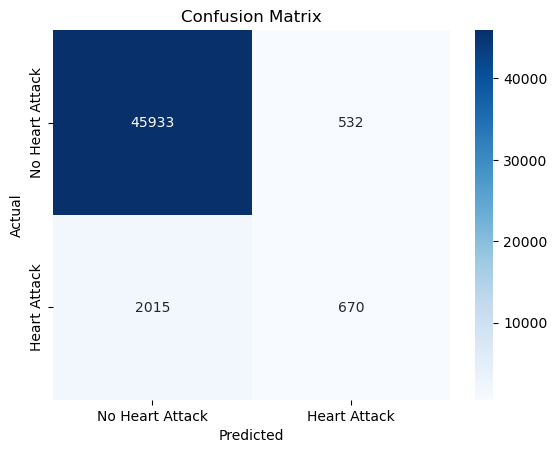

In [36]:
cm = confusion_matrix(heart_attack_status_test, heart_attack_status_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Heart Attack', 'Heart Attack'], 
            yticklabels=['No Heart Attack', 'Heart Attack'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

For our Initial logistic regression model we are getting the high accuracy which is almost 94%. But we can't get happy based on the one matrix.

<b>From the confusion matrix</b> we can say that The model does a really good job of saying when someone won't experience a heart attack (that happened correctly 45,993 times). But on the other hand, there were 2,015 times when the model said someone wouldn't have a heart attack, and they actually did. This is a big concern in a medical setting because missing these heart attacks could have bad consequences for those patients.

As we can see into the precision and recall we can tell that:-

<b>Class 0 (No Heart Attack)</b>: Really good precision (0.96) and very high recall (0.99). This means the model is very good at correctly identifying people who don't have heart attacks and rarely misclassifies them.

<b>Class 1 (Heart Attack)</b>: Low precision (0.56) and very low recall (0.25). This is not good. While about half of the people predicted to have a heart attack actually did, the model only identified 25% of all the actual heart attack cases. This means it's missing a large number of true heart attack patients (high number of false negatives).

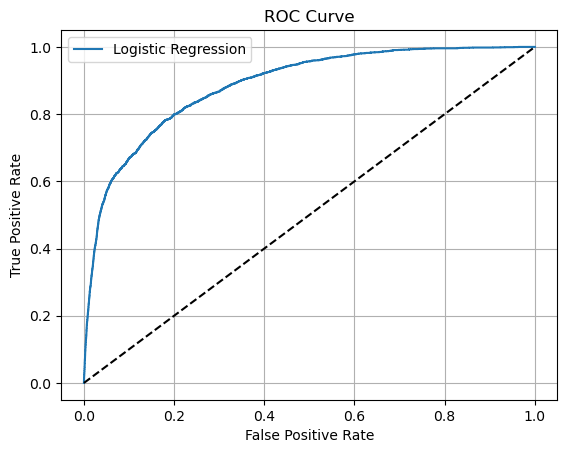

In [38]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(heart_attack_status_test, heart_attack_status_proba)
plt.plot(fpr, tpr, label='Logistic Regression')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

Now Let's try to fit our model with the parameter class_weight='balanced' which will partially resolve our class imbalance issue and then we will try to fit the model again to check if our model may predict little better.

In [40]:
# Build pipeline with logistic regression
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000))
])

# Fit the model
pipeline.fit(patient_health_train, heart_attack_status_train)

# Predict
heart_attack_status_pred = pipeline.predict(patient_health_test)
heart_attack_status_proba = pipeline.predict_proba(patient_health_test)[:, 1] 

# Evaluation
print("Accuracy:", accuracy_score(heart_attack_status_test, heart_attack_status_pred))

/opt/anaconda3/envs/heart_prediction_env/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.8280773143438453


In [41]:
print("Precision:", precision_score(heart_attack_status_test, heart_attack_status_pred))
print("Recall:", recall_score(heart_attack_status_test, heart_attack_status_pred))
print("F1 Score:", f1_score(heart_attack_status_test, heart_attack_status_pred))
print("ROC AUC:", roc_auc_score(heart_attack_status_test, heart_attack_status_proba))

print("\nClassification Report:\n", classification_report(heart_attack_status_test, heart_attack_status_pred))

Precision: 0.20768684717574282
Recall: 0.762756052141527
F1 Score: 0.32647855890323607
ROC AUC: 0.8854840340569913

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.83      0.90     46465
           1       0.21      0.76      0.33      2685

    accuracy                           0.83     49150
   macro avg       0.60      0.80      0.61     49150
weighted avg       0.94      0.83      0.87     49150



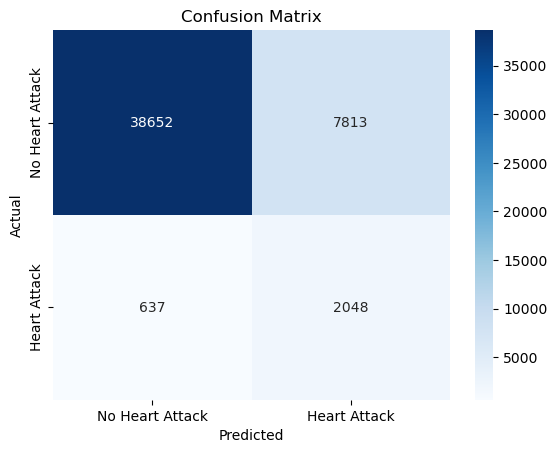

In [42]:
cm = confusion_matrix(heart_attack_status_test, heart_attack_status_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Heart Attack', 'Heart Attack'], 
            yticklabels=['No Heart Attack', 'Heart Attack'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

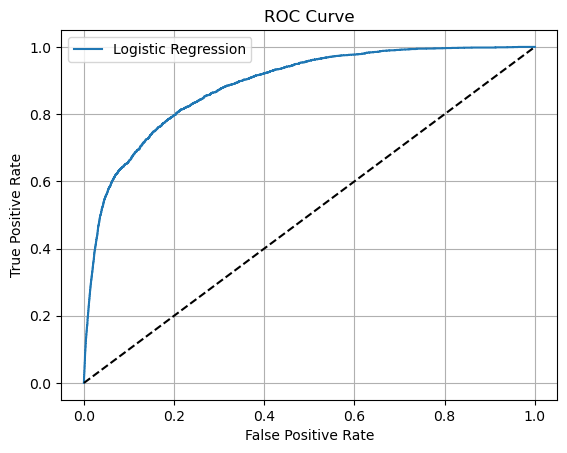

In [43]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(heart_attack_status_test, heart_attack_status_proba)
plt.plot(fpr, tpr, label='Logistic Regression')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

The ROC curve is almost same for both model so it will not useful at least for now to check which model is performing better.

<b>From the confusion matrix</b> by Comparing to our first model (which correctly identified 38,652 people who wouldn't have a heart attack), our current model's ability to predict the absence of a heart attack has slightly decreased. Now, we are incorrectly predicting a heart attack in more people who actually don't have one.

However, we've made a positive improvement in identifying individuals who will truly experience a heart attack. This number has increased to 2,048. Furthermore, the number of times we incorrectly predicted someone wouldn't have a heart attack when they actually did has significantly decreased to 637. This reduction in false negatives is a positive and crucial development in a medical context.

The overall accuracy has decreased, which is expected because we are trying to improve the performance on the minority class.

<b>Class 0 (No Heart Attack)</b>: Precision has increased slightly (0.98), but recall has significantly decreased (0.83). The model is now even better at correctly identifying those without heart attacks, but it's also missing more of them.

<b>Class 1 (Heart Attack)</b>: Though our Precision has decreased (0.21), but recall has dramatically increased (0.76). Now, the model is identifying a much larger number of actual heart attack cases (76%), but it's also incorrectly classifying many more people as having a heart attack (low precision, leading to more false positives).

### Conclusion

When comparing these two models for heart attack prediction, the second model, which used class balancing, appears to be more suitable for our needs. 

But wait why we concluded that - The reason is driven by its significantly higher recall (0.76) for the minority class (heart attack cases). This means it's successfully identifying a much larger proportion – approximately 76% – of individuals who actually experienced a heart attack. 

In this critical medical context, the cost of a false negative (predicting no heart attack when one occurred) is likely far greater than the cost of a false positive (predicting a heart attack when none occurred). While false positives may lead to further investigation, missing a true heart attack could have severe and even fatal consequences. Therefore, a higher recall, even at the expense of lower precision, is a more acceptable trade-off in this scenario.